In [1]:
import os,time
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from myEncoder.Encode import VitalSigns2Digital, VitalSigns2TXT
import re
# from wordcloud import WordCloud, ImageColorGenerator    # 词云包
# from scipy.misc import imread
from time import sleep
import jieba
import jieba.posseg as pseg#词性标注
import pkuseg#专业领域分词
from os import listdir
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, normalize
from tensorflow.keras.layers import GRU, LSTM, SimpleRNN, Bidirectional
import numpy as np
np.seterr(divide='ignore',invalid='ignore')

plt.rcParams['font.sans-serif'] = ['KaiTi']  #指定默认字体 SimHei黑体
plt.rcParams['axes.unicode_minus'] = False   #解决保存图像是负号'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tok = Tokenizer()
segcut = pkuseg.pkuseg(model_name = "medicine", user_dict = "default", postag = False)  # 程序会自动下载所对应的细领域模型
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
ed = VitalSigns2Digital()#生命指标编译成数字
et = VitalSigns2TXT()#生命指标编译成文本

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
ed = VitalSigns2Digital()#生命指标编译成数字
et = VitalSigns2TXT()#生命指标编译成文本

In [3]:
P_Values = pd.read_csv(r"./data/First_index_Perfect_0323.txt", engine='python')

In [4]:
P = pd.DataFrame(P_Values, columns=['病人ID','病人姓名','性别','出生日期','分诊时间', '分诊修改时间','分诊印象','二次分诊','到院方式','T℃', 'P(次/分)', 'R(次/分)', 'BP(mmHg)', 'SpO2','去向', '级别'])

In [5]:
len(P)

161198

In [6]:
#100000 #len(P)#len(P) #35000
length_origin = len(P)
P = P[:length_origin].fillna(value='空值')
data = P.drop(P[P['病人姓名'] == P['病人ID']].index)
data = P.drop(P[P['分诊印象'] == '空值'].index)
data['去向'].replace('动物致伤','外科',inplace = True)
data['去向'].replace('创伤中心','创伤救治中心',inplace = True)
data['去向'].replace('神外','神经外科',inplace = True)
data['分诊印象'].replace('尿储留','尿潴留',inplace = True)

data.sort_values(by='分诊时间', ascending=False, ignore_index=True)
data.reset_index(inplace=True,drop=True)

length_final = len(data)
print('数据总量：', len(data))
print('科室：', (np.unique(data['去向'])))
print('等级：', (np.unique(data['级别'])))

数据总量： 161198
科室： ['产科' '内科' '创伤救治中心' '外科' '妇科' '眼科' '神经内科' '神经外科' '耳鼻喉' '骨科']
等级： ['一级' '三级' '二级' '四级']


## 此处进行编码

In [7]:
def ClassRecord(path, name, label_sets):
    mlb = MultiLabelBinarizer()
    mlb.fit(label_sets)        
    json_file =os.path.join(path,  name + ".json")
    with open(json_file, "w", encoding="utf-8") as file_class:
        file_class.write(json.dumps(mlb.classes_.tolist(), ensure_ascii=False, indent=4))#indent:参数根据数据格式缩进显示，读起来更加清晰
    return json_file

def LabelEncoder(label_sets):
    Labels = []
    mlb = MultiLabelBinarizer()
    mlb.fit(label_sets)
    num_class = len(mlb.classes_)
    for line in tqdm(label_sets):
        Labels.append(mlb.transform([line])[0])
    return Labels, num_class

def ImpressionEncoder(length):
    clear_session()
    bert_model = BertVector(pooling_strategy="NONE", max_seq_len=length)
    f = lambda text: bert_model.encode([text])["encodes"][0]
    return f

In [8]:
segcut = pkuseg.pkuseg(model_name = "medicine", user_dict = "default", postag = False)  # 程序会自动下载所对应的细领域模型

def jieba_fc(content, stopwords):
    segment = []
    segs = segcut.cut(content)
#     segs = jieba.cut(content) 
    for seg in segs:
        if seg not in stopwords:
            segment.append(seg)
    return segment

In [9]:
# stopwords = pd.read_csv("./StopWords/common.txt",quoting=3, sep="\t", encoding='utf-8')
stopwords = pd.read_csv("./StopWords/seu_medical.txt",quoting=3, sep="\t", encoding='utf-8')
exclude = []
for i in np.asarray(stopwords):
    exclude.append(i[0])
exclude.extend(' ')

In [10]:
length = len(P) #len(P),100000

In [11]:
def Transform(data):
    ar = to_categorical(data['到院方式'].apply(lambda x : ed.Arr_way(x)))
    g =  to_categorical(data['性别'].apply(lambda x : ed.Gender(x)))
    a =  to_categorical(data['出生日期'].apply(lambda x : ed.Age(x)))
    t =  to_categorical(data['T℃'].apply(lambda x : ed.Temperature(x)))
    p =  to_categorical(data['P(次/分)'].apply(lambda x : ed.Pulse(x)))
    r =  to_categorical(data['R(次/分)'].apply(lambda x : ed.Respiration(x)))
    bp = to_categorical(data['BP(mmHg)'].apply(lambda x : ed.BloodPressure(x)))
    s =  to_categorical(data['SpO2'].apply(lambda x : ed.SpO2(x)))
    return ar, g, a, t, p, r, bp, s

def Norm(data, options):
    data = [normalize(np.array([i]), norm= options) for i in data]
    return data

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, normalize
from tensorflow.keras.backend import clear_session
from albert_zh.extract_feature import BertVector

start0 = time.perf_counter()
VS = np.hstack(Transform(data[:length]))
VS_n = np.array(Norm(VS, 'l2'))
Data_VS_norm = VS_n.squeeze()

im = data[:length]['分诊印象'].apply(lambda x : "".join(jieba_fc(x, exclude)))
max_seq_len= np.max(np.max([len(i) for i in im]))
mlb = MultiLabelBinarizer()
IMP = ImpressionEncoder(max_seq_len)
Impression=[]
# 利用ALBERT对(文本）进行编码
print('begin encoding')
for line1 in tqdm(im):
    Impression.append(IMP(line1))
print('end encoding')
end0 = time.perf_counter()
Time_transfer = (end0 - start0)/len(im)

I:BERT_VEC:[graph:opt: 48]:model config: D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\albert_zh/albert_tiny\albert_config_tiny.json
I:BERT_VEC:[graph:opt: 54]:build graph...


embedding_lookup_factorized. factorized embedding parameterization is used.
ln_type: postln
old structure of transformer.use: transformer_model,which use post-LN


I:BERT_VEC:[graph:opt:128]:load parameters from checkpoint...
I:BERT_VEC:[graph:opt:130]:freeze...
I:BERT_VEC:[graph:opt:133]:optimize...
I:BERT_VEC:[graph:opt:144]:write graph to a tmp file: ./tmp_graph11


begin encoding


100%|██████████████████| 161198/161198 [04:09<00:00, 647.14it/s]

end encoding


In [13]:
y1= pd.get_dummies(data[:length]['级别']).values
y2= pd.get_dummies(data[:length]['去向']).values

dic1={'一级':0, '二级':1, '三级':2, '四级':3}
dic2={'产科':0, '内科':1, '创伤救治中心':2, '外科':3, '妇科':4, '眼科':5, '神经内科':6, '神经外科':7, '耳鼻喉':8,'骨科':9}
# dic2=dict([(value,key) for (key,value) in dic.items()])
Y1=data[:length]['级别'].map(dic1).values
Y2=data[:length]['去向'].map(dic2).values
Y3=np.array([[Y1[i], Y2[i]] for i in tqdm(range(len(Y1)))])
print("Data_Concate.shape: ", np.array(Data_VS_norm).shape)
print("Y1.shape: ", Y1.shape)
print("Y2.shape: ", Y2.shape)
print("Y3.shape: ", Y3.shape)

100%|███████████████| 161198/161198 [00:00<00:00, 182462.87it/s]


Data_Concate.shape:  (161198, 30)
Y1.shape:  (161198,)
Y2.shape:  (161198,)
Y3.shape:  (161198, 2)


In [14]:
# from torch.utils.data import DataLoader
class MyDataset():
    def __init__(self, datasetA, datasetB, Label):
        self.datasetA = datasetA
        self.datasetB = datasetB
        self.Label = Label
        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        Label = self.Label[index]
        return xA, xB, Label
    
    def __len__(self):
        return len(self.datasetA)

In [15]:
datasetA = Data_VS_norm
datasetB = Impression

# new_matrix = list(map(lambda l: np.append(l,[0]*(312-len(l))), datasetA))
# VS_Extend = np.array([[i] for i in new_matrix])
# datasetC = np.hstack([VS_Extend, datasetB]) #solomodule & E-TransNet

In [16]:
X_l = datasetA
X_ld = datasetB
Y_l = Y3[:, 0]
Y_d = Y3[:, 1]
np.unique(Y_l),np.unique(Y_d)

(array([0, 1, 2, 3], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64))

# 构建神经网络

In [17]:
from Transformer.transformer import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Average, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Dense,Input, Dropout, Embedding, Flatten,MaxPooling1D,Conv1D,SimpleRNN,LSTM,GRU,Multiply,GlobalMaxPooling1D
from tensorflow.keras.models import Model
from att import Attention

Using TensorFlow backend.


In [18]:
x_train_l = np.array([i.reshape(1,-1) for i in X_l] )
x_train_d = np.array([i for i in X_ld])
y_train_l, y_train_d = [np.array(to_categorical(i)) for i in [Y_l, Y_d]]

In [19]:
maxlen_l = x_train_l.shape[2]   # Only consider the first 200 words of each movie review
maxlen_d = x_train_d.shape[1]   # Only consider the first 200 words of each movie review
num_labels1=y_train_l.shape[1] #4分类
num_labels2=y_train_d.shape[1] #10分类
maxlen_l, maxlen_d, num_labels1, num_labels2

(30, 31, 4, 10)

In [20]:
def PB_TextRNN():#稍作改动，以便维度对齐
    inputs1 = layers.Input(shape=(1, maxlen_l,), name="input1")
    inputs2 = layers.Input(shape=(maxlen_d,312,), name="input2")
    
    #Text
    def Text(inputs1):
        cnn1  = LSTM(32, dropout=0.2, return_sequences=True)(inputs1)
        cnn1 = MaxPooling1D(pool_size=2, padding='same')(cnn1)
        cnn2 = Conv1D(32, 4, padding='same', strides = 1, activation='relu')(inputs1)
        cnn2 = MaxPooling1D(pool_size=2, padding='same')(cnn2)
        cnn3 = Conv1D(32, 5, padding='same', strides = 1, activation='relu')(inputs1)
        cnn3 = MaxPooling1D(pool_size=2, padding='same')(cnn3)
        cnn4 = layers.concatenate([cnn1,cnn2,cnn3], axis=-1)
        cnn5 = LSTM(32, dropout=0.2, return_sequences=True)(cnn4)
        cnn6 = MaxPooling1D(pool_size=2, padding='same')(cnn5)
        return cnn6
    #RNN
    def RNN(inputs2):
        bilstm = Bidirectional(LSTM(32, dropout=0.2, return_sequences=True))(inputs2)
        x2 = layers.Dropout(0.1)(bilstm)
#         x2 = layers.concatenate([x2, x2, x2, x2], axis=1)
        mp1 = MaxPooling1D(pool_size=2)(x2)  
        conv1 = Conv1D(32, 3, padding='same', strides = 1, activation='relu')(mp1)
        lstm = MaxPooling1D(pool_size=2)(conv1)
        return lstm
    if type_mode=='Normal':
        concat = layers.concatenate([Text(inputs1), RNN(inputs2)], axis=1)
        ConcatFeature = Attention(16, name="attention1")(concat)    
    elif type_mode=='WText':
        ConcatFeature = Attention(16, name="attention1")(RNN(inputs2))
    elif type_mode=='WF':
        concat = layers.concatenate([Text(inputs1), RNN(inputs2)], axis=1)
        ConcatFeature = Attention(16, name="attention1")(concat)          
    elif type_mode=='WAtt':
        concat = layers.concatenate([Text(inputs1), RNN(inputs2)], axis=1)
        ConcatFeature = layers.Flatten()(concat)    
    output1 = layers.Dense(num_labels1, activation='softmax', name="dense1")(ConcatFeature)
    output2 = layers.Dense(num_labels2, activation='softmax', name="dense2")(ConcatFeature)
#     model = Model(inputs=[inputs2], outputs=[output1, output2])
    model = Model(inputs=[inputs1,inputs2], outputs=[output1, output2])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

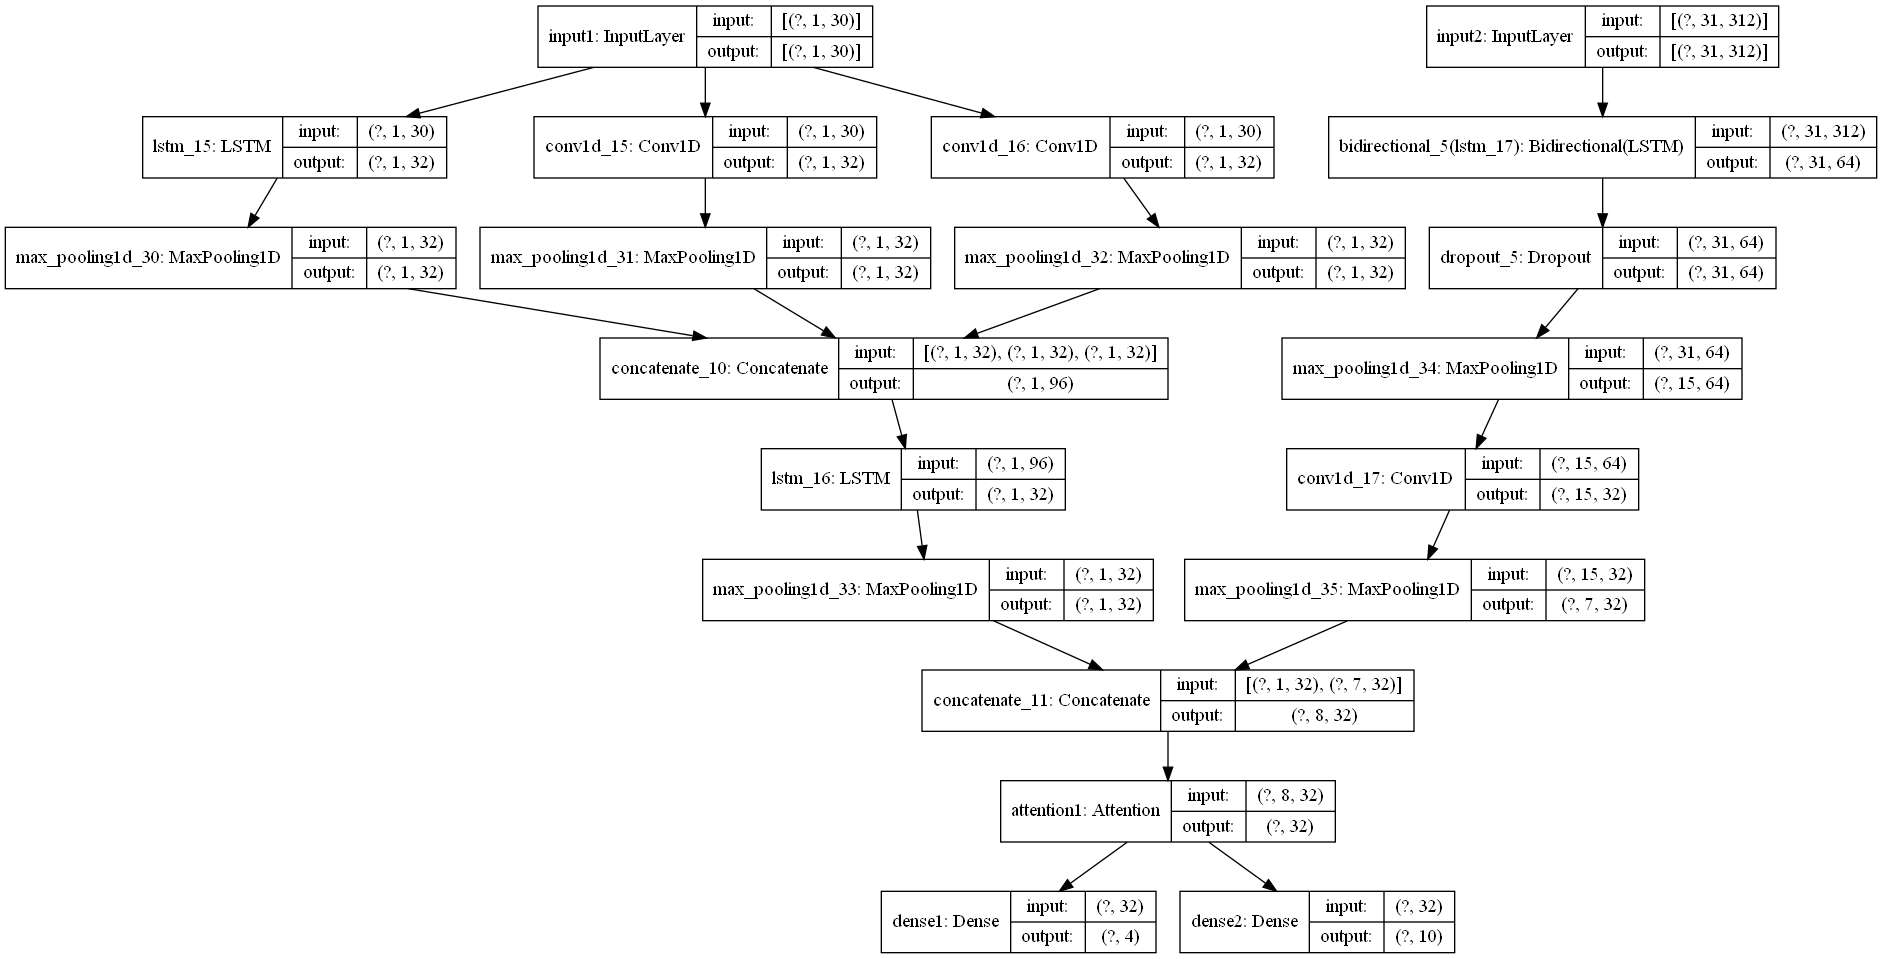

In [76]:
from tensorflow.keras.utils import plot_model
type_mode = 'WF'
model = PB_TextRNN()
plot_model(model, show_shapes = True)

## AI分诊

In [21]:
import glob
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, cohen_kappa_score, matthews_corrcoef
from ROC_AUC_FM.TFPN_Func import *

seed = 42  # 随机种子
np.random.seed(seed)  # 生成固定的随机数
num_k = 5  # 多少折
# 整个数据集(自己定义)
X_ = X_ld
Y_ = Y_l
kfold = StratifiedKFold(n_splits=num_k, shuffle=True, random_state=seed) 

In [22]:
dic3={0:'一级', 1:'二级', 2:'三级', 3:'四级'}
dic4={0:'产科', 1:'内科', 2:'创伤救治中心', 3:'外科', 4:'妇科',5: '眼科', 6:'神经内科', 7:'神经外科', 8:'耳鼻喉',9:'骨科'}
name1 ={0: 'Level', 1: 'Department', 2:'综合'}
name2 ={0:'ACC(weight)',1:'Sensitivity',2:'Specificity',3:'G_Mean',4:'F1-score',5:'PPV',6:'NPV',7:'KAPPA'}
dic = {0: dic3, 1: dic4}
LABEL ={0:'Level', 1:'Department'}
labels_name1 = ("一级", "二级", "三级", "四级")
labels_name2 = ("产科", "内科", "创伤", "外科", "妇科", "眼科", "神内", "神外", "耳鼻喉", "骨科")

In [23]:
def LevelDepat(list_name):
    Lev=[]
    Dep=[]
    for name in list_name:
        for _, i in enumerate(name):
            if i =='^':
                Lev.append(name[_+39: _+45])
                Dep.append(name[-9: -3])
    Level = [float(i) for i in Lev]
    Depart = [float(i) for i in Dep]
    return Level, Depart

In [31]:
type_mode = 'WF'
model = PB_TextRNN()

NAME = 'B_TextRNN_WF'
path_model = r'D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\BERT'+ '/'+ NAME
folderlist_name = os.listdir(path_model)
FileName=[]
NAME_ = []
for i in range(len(folderlist_name)):
    ValueMax=[]
    Path=os.path.join(path_model, str(folderlist_name[i]))
#     os.chdir(Path)
    list_name = os.listdir(Path)
    list_name.sort(key=lambda x: int(x.split("^")[0])) 
    L, D = LevelDepat(list_name)
    ValueMax.append([np.sqrt(L[i]*L[i]+D[i]*D[i]) for i in range(len(L))])
    ind = ValueMax[0].index(max(ValueMax[0]))
    FileName.append(os.path.join(Path,list_name[ind]))
    NAME_.append(list_name[ind])

In [32]:
FileName

['D:\\Triage\\Bayesian_Network\\NewTriage\\Revise\\KFold\\weight\\ablation\\BERT/B_TextRNN_WF\\1\\36^lt0.5594-Lt0.8534-Dt0.9061-lv0.5854-Lv0.8360-Dv0.9193.h5',
 'D:\\Triage\\Bayesian_Network\\NewTriage\\Revise\\KFold\\weight\\ablation\\BERT/B_TextRNN_WF\\2\\46^lt0.5552-Lt0.8544-Dt0.9082-lv0.5862-Lv0.8339-Dv0.9210.h5',
 'D:\\Triage\\Bayesian_Network\\NewTriage\\Revise\\KFold\\weight\\ablation\\BERT/B_TextRNN_WF\\3\\18^lt0.5867-Lt0.8498-Dt0.9016-lv0.5862-Lv0.8353-Dv0.9196.h5',
 'D:\\Triage\\Bayesian_Network\\NewTriage\\Revise\\KFold\\weight\\ablation\\BERT/B_TextRNN_WF\\4\\35^lt0.5662-Lt0.8525-Dt0.9053-lv0.5864-Lv0.8343-Dv0.9222.h5',
 'D:\\Triage\\Bayesian_Network\\NewTriage\\Revise\\KFold\\weight\\ablation\\BERT/B_TextRNN_WF\\5\\31^lt0.5666-Lt0.8512-Dt0.9061-lv0.5873-Lv0.8344-Dv0.9201.h5']

In [33]:
for i in range(len(NAME_)):
    ValueMax1=[]
    L1, D1 = LevelDepat(NAME_)
    ValueMax1.append([np.sqrt(L1[i]*L1[i]+D1[i]*D1[i]) for i in range(len(L1))])
    ind1 = ValueMax1[0].index(max(ValueMax1[0]))
weight =NAME_[ind1]
train, test = list(kfold.split(X_, Y_))[NAME_.index(NAME_[ind1])]

FileName1=[]
for inde, weightfile in enumerate(FileName):
    if weight in weightfile:
        FileName1.append(FileName[inde])

In [34]:
FileName1

['D:\\Triage\\Bayesian_Network\\NewTriage\\Revise\\KFold\\weight\\ablation\\BERT/B_TextRNN_WF\\4\\35^lt0.5662-Lt0.8525-Dt0.9053-lv0.5864-Lv0.8343-Dv0.9222.h5']

In [35]:
def Model_Name1(path_weight, model, x_test):
    model.load_weights(path_weight,by_name=False)
    predictions = model.predict(x_test)
    y_predict_l = np.argmax(predictions[0], axis=1)
    y_predict_d = np.argmax(predictions[1], axis=1)
    return y_predict_l, y_predict_d

In [36]:
x_train_l.shape, x_train_d.shape

((161198, 1, 30), (161198, 31, 312))

In [37]:
Results = []
k = 0#新建文件夹命名
path = FileName1[0]
k+=1
result = []
print('*'*10, '%d-Fold'%(k),'*'*10)
x_test = [x_train_l[test], x_train_d[test]]
Y_test = [Y_l[test], Y_d[test]]
y_predict = Model_Name1(path, model, x_test)

********** 1-Fold **********


### 整体精度测试

In [38]:
y_predict

(array([3, 3, 3, ..., 3, 3, 3], dtype=int64),
 array([1, 3, 3, ..., 3, 1, 6], dtype=int64))

In [39]:
y_true1 = Y_l[test]
y_true2 = Y_d[test]
y_pred1 = y_predict[0]
y_pred2 = y_predict[1]
dic6_1={0:'L1', 1:'L2', 2:'L3', 3:'L4'}
dic7_1={0:'Ob', 1:'IM', 2:'TC', 3:'S', 4:'G',5: 'Op', 6:'Nl', 7:'Ns', 8:'Ot',9:'Or'}

In [40]:
y_fusion_gt_e = []
y_fusion_pred_e = []
for i in range(len(y_predict[0])):
    y_fusion_gt_e.append([dic6_1[y_true1[i]]+dic7_1[y_true2[i]]])
    y_fusion_pred_e.append([dic6_1[y_pred1[i]]+dic7_1[y_pred2[i]]])

In [41]:
from sklearn.metrics import accuracy_score
B_TextRNN = accuracy_score(y_fusion_gt_e, y_fusion_pred_e)
print('B_TextRNN:%.4f'%B_TextRNN)

B_TextRNN:0.7747


### 混淆矩阵

In [42]:
from ROC_AUC_FM.ConfusionMatrix import *

def OUTriage(matrix):
    up = (np.triu(matrix, k=1)).sum()#上三角
    triu = (np.diag(matrix)).sum()#对角
    allsum = matrix.sum()
    down = allsum-triu-up#下三角
    acc = triu/ allsum
    overtriage= down/allsum
    undertriage=up/allsum
    return overtriage, undertriage,acc

def UDDofMatrix(matrix):
    up = (np.triu(matrix, k=1)).sum()#上三角
    triu = (np.diag(matrix)).sum()#对角
    allsum = matrix.sum()
    down = allsum-triu-up#下三角
    return up, down, triu, allsum

In [43]:
labels_name_gt2 = np.unique((y_fusion_gt_e + y_fusion_pred_e), return_counts=False)
labels_name_gt2, len(labels_name_gt2)

(array(['L1IM', 'L1Nl', 'L1S', 'L1TC', 'L2IM', 'L2Nl', 'L2Ob', 'L2S',
        'L2TC', 'L3G', 'L3IM', 'L3Nl', 'L3Ns', 'L3Ob', 'L3Op', 'L3Or',
        'L3Ot', 'L3S', 'L4G', 'L4IM', 'L4Nl', 'L4Ns', 'L4Ob', 'L4Op',
        'L4Or', 'L4Ot', 'L4S', 'L4TC'], dtype='<U4'),
 28)

In [44]:
# labels_name_l=('Level1','Level2','Level3 ', 'Level4')
labels_name_l=('L1','L2','L3 ', 'L4')
labels_name_d = ('Ob','IM','TC ', 'S', 'G','Op','Nl', 'Ns','Ot','Or')
labels_name_gt = np.unique(y_fusion_gt_e)
labels_pred_e = np.unique(y_fusion_pred_e)
labels_name_gt2 = np.unique((y_fusion_gt_e + y_fusion_pred_e), return_counts=False)

labels_named = {0:labels_name_l, 1: labels_name_d, 2: labels_name_gt2}

In [45]:
matrix_w = confusion_matrix(y_fusion_gt_e, y_fusion_pred_e)
matrix_l = confusion_matrix(y_true1, y_pred1)
matrix_d = confusion_matrix(y_true2, y_pred2)

In [46]:
for ind, i in enumerate([matrix_l, matrix_d, matrix_w]):
    save_path2 =  r'D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\FigRecord\ConfusionMatrix\TextRNN\Triage'
    if not os.path.exists(save_path2):
         os.makedirs(save_path2)
    np.savetxt(save_path2+'/' +str(ind)+'.txt', i, fmt='%d')

In [47]:
for ind, i in enumerate([matrix_l, matrix_d, matrix_w]):
    overtriage, undertriage,acc = OUTriage(i)
    print('*'*10)
    print("{:s}\n OverTriage:{:.4f}\n UnderTriage:{:.4f}\n Coomon Triage:{:.4f}".format(name1[ind],overtriage, undertriage, acc))
    

for ind, i in enumerate([matrix_w]):
    up, down, triu, allsum = UDDofMatrix(i)
    print('\n','*'*20)
    print("数据量：\n OverTriage:{:d}\n Undertriage:{:d}\n Triu:{:d}\n ALL:{:d}".format(down,up, triu, allsum))

**********
Level
 OverTriage:0.0794
 UnderTriage:0.0764
 Coomon Triage:0.8442
**********
Department
 OverTriage:0.0338
 UnderTriage:0.0580
 Coomon Triage:0.9082
**********
综合
 OverTriage:0.1020
 UnderTriage:0.1233
 Coomon Triage:0.7747

 ********************
数据量：
 OverTriage:3289
 Undertriage:3975
 Triu:24975
 ALL:32239


In [50]:
def plot_confusion_matrix2(matrix, labels_name, title, cmap=plt.cm.Blues):#cmap='Blues'

    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]    # 归一化
    from matplotlib.colors import LogNorm
    plt.imshow(matrix, interpolation='nearest',cmap=cmap)    # 在特定的窗口上显示图像
#     plt.title(NAME_csv, fontdict={'family': 'Times New Roman', 'size': 20, 'weight'  : "bold"})    # 图像标题
#     plt.colorbar()

    
    bwith = 1.5 #边框宽度设置为2
    ax = plt.gca()#获取边框
#     ax.spines['top'].set_color('red')  # 设置上‘脊梁’为红色
#     ax.spines['right'].set_color('none')  # 设置上‘脊梁’为无色
    ax.spines['bottom'].set_linewidth(bwith)
    ax.spines['left'].set_linewidth(bwith)
    ax.spines['top'].set_linewidth(bwith)
    ax.spines['right'].set_linewidth(bwith)
    
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    
    plt.tick_params(labelsize=18, width=1)#综合8， leve,department:l8
    
    plt.rcParams['font.sans-serif']=['Times New Roman'] #['Times New Roman'] # ['SimSun']宋体；['SimHei']黑体，有很多自己都可以设置
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.ylabel('True label', fontdict={'family': 'Times New Roman','weight' : "bold", 'size': 20})#综合12 ， level 20   
    plt.xlabel('Predicted label', fontdict={'family': 'Times New Roman', 'weight'  : "bold", 'size': 20})
    plt.tight_layout()
    
def DrawFusionMatrix2(matrix, labels_name, name, path):
    threshold = 0
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i, j] >= threshold:
                plt.annotate(matrix[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center',
                             weight="bold", color="r", fontsize=18, family="Times New Roman")#综合4, level 18, department6
            else:
                text = plt.text(j, i, "", ha="center", va="center")

    plot_confusion_matrix2(matrix, labels_name, "Confusion Matrix")
    plt.savefig(path + '/' + name + '_English.svg', format='svg', bbox_inches='tight', transparent=True, dpi=200)
    plt.show()

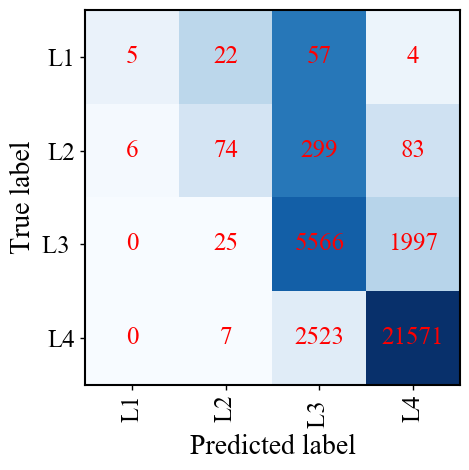

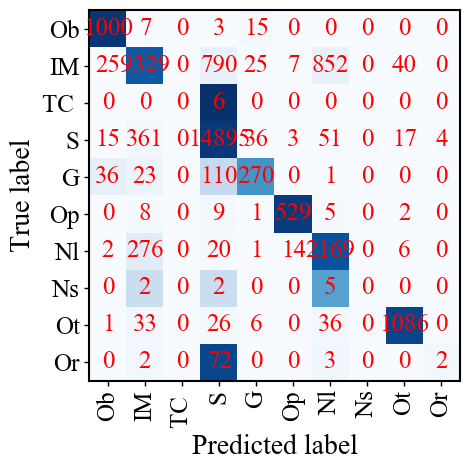

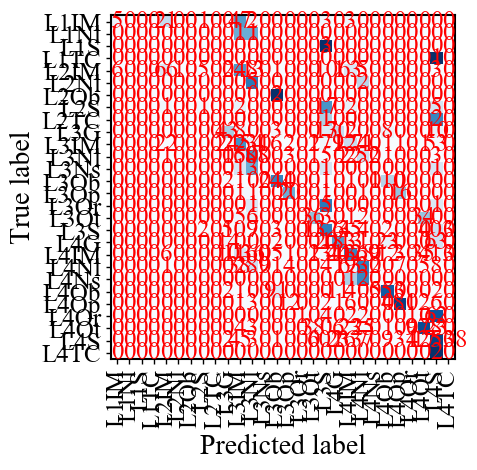

In [51]:
import seaborn as sns

path = save_path2
for ind, i in enumerate([matrix_l, matrix_d]):#matrix_l, matrix_d, matrix_w
    name = name1[ind]
    DrawFusionMatrix2(i, labels_named[ind], name, path)
DrawFusionMatrix2(matrix_w, labels_named[2], name1[2], path)